In [8]:
from math import *
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib.pyplot as plt
import random
import statistics
from IPython.display import Image
import lightgbm as lgb
import codecs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

In [9]:
test = pd.read_csv(r"c:\work\dataset\titanic\test.csv", ",")
train = pd.read_csv(r"c:\work\dataset\titanic\train.csv", ",")
test["is_test"] = True
train["is_test"] = False
common = pd.concat([test, train],axis=0).loc[:,["PassengerId", "Survived", "is_test", "Age", "Cabin", "Embarked", "Fare", "Name", "Parch", "Pclass", 
                                            "Sex", "SibSp", "Ticket"]]
t = train.groupby(by="Ticket", as_index=False).agg({"PassengerId" : 'count', "Sex" : lambda x : x[x=="female"].count()})
t.columns = ["Ticket", "SameTicket", "FemalesOnTicket"]
common = pd.merge(common, t, how="left", on="Ticket")

common["DoubleName"] = common["Name"].str.contains("\(")
common["NameLen"] = common["Name"].str.len()
common["TicketDigits"] = pd.to_numeric(common["Ticket"].str.split(" ").str[-1], errors="coerce").astype(np.str).str.len()
common["TicketIsNumber"] = ~common["Ticket"].str.contains("[A-Za-z]", regex = True)
common["Family"] = common["Parch"] + common["SibSp"] + 1
common["AverageFareByFamily"] = common["Fare"] / common["Family"]
common["AverageFareByTicket"] = common["Fare"] / common["SameTicket"]
common["Alone"] = common["Family"] == 1
common["FareLog"] = np.log(common["Fare"])

cap = train.groupby(by="Cabin", as_index=False).agg({"PassengerId" : 'count'})
cap.columns = ["Cabin", "SameCabin"]
common = pd.merge(common, cap, how="left", on="Cabin")

common["CabinNumber"] = pd.to_numeric(common["Cabin"].str[1:], errors = "coerce")
common["CabinEven"] = common["CabinNumber"] %2
common["CabinsPerMan"] = common["Cabin"].str.split(" ").str.len()
common["Deck"] = common["Cabin"].str[0].rank().fillna(-1)

decktarget = common.groupby(by="Deck", as_index=False).agg({"Survived" : 'mean'})
decktarget.columns = ["Deck", "TargetByDeck"]
common = pd.merge(common, decktarget, how="left", on="Deck")

common["Title"] = common["Name"].str.split(", ").str[1].str.split(" ").str[0]
common.loc[common["Title"].str[-1]!=".", "Title"]="Bad"
rare_title = common["Title"].value_counts()[common["Title"].value_counts() < 5].index
common["Title"] = common["Title"].apply(lambda x: 'Rare' if x in rare_title else x)

titletarget = common.groupby(by="Title", as_index=False).agg({"Survived" : 'mean'})
titletarget.columns = ["Title", "TargetByTitle"]
common = pd.merge(common, titletarget, how="left", on="Title")

common['AgeGroup'] = pd.qcut(common['Age'].fillna(common['Age'].mean()).astype(int), 6)
agetarget = common.groupby(by="AgeGroup", as_index=False).agg({"Survived" : 'mean'})
agetarget.columns = ["AgeGroup", "TargetByAgeGroup"]
common = pd.merge(common, agetarget, how="left", on="AgeGroup")

common["IsTinyChild"] = common["Age"]<1
common["IsChild"] = common["Age"]<10
common["AverageAge"] = common["Age"] / common["Family"]
common["FemalesPerTicketPart"] = common["FemalesOnTicket"]/common["SameTicket"]
#common["Sex"] = common["Sex"].apply(lambda x: 1 if x=="female" else 0)
common['FareGroup'] = pd.qcut(common['Fare'].fillna(common['Fare'].mean()).astype(int), 6)

faretarget = common.groupby(by="FareGroup", as_index=False).agg({"Survived" : 'mean'})
faretarget.columns = ["FareGroup", "TargetByFareGroup"]
common = pd.merge(common, faretarget, how="left", on="FareGroup")

pclasstarget = common.groupby(by="Pclass", as_index=False).agg({"Survived" : 'mean'})
pclasstarget.columns = ["Pclass", "TargetByPclass"]
common = pd.merge(common, pclasstarget, how="left", on="Pclass")

Embarkedtarget = common.groupby(by="Embarked", as_index=False).agg({"Survived" : 'mean'})
Embarkedtarget.columns = ["Embarked", "TargetByEmbarked"]
common = pd.merge(common, Embarkedtarget, how="left", on="Embarked")

Sextarget = common.groupby(by="Sex", as_index=False).agg({"Survived" : 'mean'})
Sextarget.columns = ["Sex", "TargetBySex"]
common = pd.merge(common, Sextarget, how="left", on="Sex")

In [10]:
allfeatures = [
    "PassengerId", 
    "is_test", 
    "Survived", 
    "Age", 
    "Fare", 
    "Parch", 
    "Pclass",
    "SibSp", 
    "Sex", 
    "Embarked", 
    "SameTicket", 
    "FemalesOnTicket", 
    "SameCabin", 
    "Deck", 
    "TargetByDeck", 
    "TargetByTitle", 
    "TargetByAgeGroup", 
    "TargetByFareGroup",
    "TargetByPclass",
    "TargetByEmbarked",
    "TargetBySex",
    "Title", 
    "CabinNumber", 
    "CabinEven", 
    "CabinsPerMan", 
    "DoubleName", 
    "NameLen", 
    "TicketDigits",
    "TicketIsNumber",
    "IsTinyChild", 
    "IsChild", 
    "Alone", 
    "Family", 
    "AverageAge",
    "AverageFareByFamily",
    "AverageFareByTicket",
    "FemalesPerTicketPart"
]

c = common.loc[:, allfeatures]
c = pd.get_dummies(c, columns=[
    "Title", 
    "Embarked", 
    "Pclass",
    "Sex"
])

c_columns = c.columns
c_index = c.index
imp = Imputer(strategy="most_frequent")
c = pd.DataFrame(imp.fit_transform(c))
c.columns = c_columns
c.index = c_index



dep = c[c["is_test"] == False].loc[:, ["Survived"]]
indep = c[c["is_test"] == False].iloc[:, 3:]
res = c[c["is_test"] == True].iloc[:, 3:]
res_index = c[c["is_test"] == True].loc[:, "PassengerId"]

indep_columns = indep.columns
indep_result_columns = res.columns
indep_index = indep.index
indep_result_index = res.index

rs = StandardScaler()

indep =  pd.DataFrame(rs.fit_transform(indep))
res = pd.DataFrame(rs.fit_transform(res))

indep.columns = indep_columns
res.columns = indep_result_columns
indep.index = indep_index
res.index = indep_result_index


indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=47)

indep.head(200)

,Age,Fare,Parch,SibSp,SameTicket,FemalesOnTicket,SameCabin,Deck,TargetByDeck,TargetByTitle,TargetByAgeGroup,TargetByFareGroup,TargetByPclass,TargetByEmbarked,TargetBySex,CabinNumber,CabinEven,CabinsPerMan,DoubleName,NameLen,TicketDigits,TicketIsNumber,IsTinyChild,IsChild,Alone,Family,AverageAge,AverageFareByFamily,AverageFareByTicket,FemalesPerTicketPart,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Rev.,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
418,-0.497793,-0.502445,-0.473674,0.432793,-0.579162,-0.760987,-0.319735,-0.459297,-0.517650,-0.817836,-0.883769,-0.977720,-0.856082,-0.541542,-0.737695,-0.365093,-0.314076,-0.151265,-0.437237,-0.427451,-0.369096,-1.695262,-0.088986,-0.273476,-1.231645,0.059160,-0.833955,-0.454798,-0.496976,-0.858001,-0.088986,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587,-0.737695,0.737695
419,0.715048,0.786845,-0.473674,0.432793,-0.579162,0.280548,-0.319735,1.348609,1.290563,1.469456,0.912246,1.810331,1.487302,2.042658,1.355574,2.956846,3.183944,-0.151265,2.287087,2.590962,-0.369096,-1.695262,-0.088986,-0.273476,-1.231645,0.059160,-0.250952,0.438994,2.522573,1.576646,-0.088986,-0.216803,-0.506655,-1.175735,2.475480,-0.126347,-0.082339,2.074505,-0.307562,-1.614710,1.767767,-0.510152,-1.107926,1.355574,-1.355574
420,-0.194583,-0.488854,-0.473674,-0.474545,-0.579162,0.280548,-0.319735,-0.459297,-0.517650,1.130326,-0.969801,-0.977720,-0.856082,-0.541542,1.355574,-0.365093,-0.314076,-0.151265,-0.437237,-0.535252,1.766386,-1.695262,-0.088986,-0.273476,0.811922,-0.560975,0.259176,-0.334757,-0.465145,1.576646,-0.088986,-0.216803,1.973729,-1.175735,-0.403962,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587,1.355574,-1.355574
421,0.487640,0.420730,-0.473674,0.432793,0.155928,0.280548,1.686492,1.348609,1.290563,1.469456,0.912246,0.039480,1.487302,-0.541542,1.355574,4.554740,3.183944,-0.151265,2.287087,1.836359,0.698645,0.589879,-0.088986,-0.273476,-1.231645,0.059160,-0.360265,0.185187,0.413134,0.359322,-0.088986,-0.216803,-0.506655,-1.175735,2.475480,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,1.767767,-0.510152,-1.107926,1.355574,-1.355574
422,0.487640,-0.486337,-0.473674,-0.474545,-0.579162,-0.760987,-0.319735,-0.459297,-0.517650,-0.817836,0.912246,-1.401863,-0.856082,-0.541542,-0.737695,-0.365093,-0.314076,-0.151265,-0.437237,-0.319651,0.698645,0.589879,-0.088986,-0.273476,0.811922,-0.560975,0.915054,-0.331267,-0.459251,-0.858001,-0.088986,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,-0.565685,-0.510152,0.902587,-0.737695,0.737695
423,-0.346188,-0.478116,-0.473674,-0.474545,-0.579162,-0.760987,-0.319735,-0.459297,-0.517650,-0.817836,-0.969801,-1.401863,-0.856082,0.086615,-0.737695,-0.365093,-0.314076,-0.151265,-0.437237,-1.182055,0.698645,0.589879,-0.088986,-0.273476,0.811922,-0.560975,-0.105201,-0.319869,-0.439997,-0.858001,-0.088986,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,-0.482043,3.251373,-1.614710,-0.565685,-0.510152,0.902587,-0.737695,0.737695
424,1.927889,0.395814,-0.473674,-0.474545,-0.579162,-0.760987,-0.319735,2.862980,2.256902,-0.817836,-0.169168,0.039480,1.487302,-0.541542,-0.737695,1.316901,-0.314076,-0.151265,-0.437237,-0.427451,-0.369096,0.589879,-0.088986,-0.273476,0.811922,-0.560975,2.299686,0.891823,1.606768,-0.858001,-0.088986,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,1.767767,-0.510152,-1.107926,-0.737695,0.737695
425,-2.013845,-0.224083,0.767630,2.247470,1.626108,2.363618,-0.319735,-0.459297,-0.517650,0.688216,1.562066,0.587607,-0.856082,-0.541542,-0.737695,-0.365093,-0.314076,-0.151265,-0.437237,0.327152,0.698645,0.589879,-0.088986,3.656633,-1.231645,1.919564,-1.606434,-0.438327,-0.590403,0.967984,-0.088986,4.612483,-0.506655,-1.175735,-0.403962,-0.126347,-0.082339,-0.482043,-0.307562,0.619306,-0.565685,-0.510152

In [11]:
#{'lambda_l1': 0.9292513357434378, 'lambda_l2': 0.30227594050854933, 'learning_rate': 0.9684407965914154, 'max_depth': 9.0}

gs1 = lgb.LGBMClassifier(max_depth = 10,
                         lambda_l1 = 0.1,
                         lambda_l2 = 0.01,
                         learning_rate = 0.44, 
                         n_estimators = 500, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                         n_jobs = 5)
gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)], eval_metric='accuracy', verbose=False, early_stopping_rounds=50);



g = gs1.predict(res)
a = accuracy_score(dep_test, gs1.predict(indep_test))
b = accuracy_score(dep_train, gs1.predict(indep_train))
#cv = cross_val_score(gs1, indep_train, dep_train, cv=5)
print(a, b)


0.834733893557 0.893258426966


In [16]:
for j in range(90, 91, 1):
    model = []
    for i in range(0,j):
        indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=i)
        gs1 = lgb.LGBMClassifier(max_depth = 7,
                                 lambda_l1 = 0.1,
                                 lambda_l2 = 0.01,
                                 learning_rate =  0.01, num_iterations=20000,
                                 n_estimators = 5000, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                                 n_jobs = 5, boosting='dart' )
        gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)], eval_metric='accuracy', verbose=False, early_stopping_rounds=50);
        model.append(gs1)

    data = pd.DataFrame()
    te = pd.DataFrame()
    for i in range(0,j):
        data[i] = model[i].predict(res)
        te[i] = model[i].predict(indep_test)

    g = np.round(data.mean(axis=1))
    t = np.round(te.mean(axis=1))


    print(j, accuracy_score(dep_test, t))


90 0.910364145658


In [7]:
indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=47)
for i in range(1,20):
#for j in range(1,110):
    params = {}
    params["max_depth"] = 7
    params["learning_rate"] = 0.424
    params["lambda_l1"] = 0.1
    params["lambda_l2"] = 0.01
    params["n_estimators"] = 5000
    params["n_jobs"]=5 
    params["objective"] = "binary"
    
    params["boosting"] = "dart"
    params["colsample_bytree"] = 0.9
    params["subsample"] = i/20

    train_data = lgb.Dataset(data=indep_train, label=dep_train, free_raw_data=False, feature_name = list(indep_train))
    cv_result = lgb.cv(params, train_data, nfold=50, stratified=False, metrics=['binary_error'], early_stopping_rounds=5)
    print(i, 1-np.mean(cv_result["binary_error-mean"]))


1 0.823578947368
2 0.823578947368
3 0.823578947368
4 0.823578947368
5 0.823578947368
6 0.823578947368
7 0.823578947368
8 0.823578947368
9 0.823578947368
10 0.823578947368
11 0.823578947368
12 0.823578947368
13 0.823578947368
14 0.823578947368
15 0.823578947368
16 0.823578947368
17 0.823578947368
18 0.823578947368
19 0.823578947368


In [17]:
result = pd.DataFrame(res_index.astype(np.int), columns=["PassengerId"])
result["Survived"] = g.astype(np.int)
result.to_csv(r"c:\work\dataset\titanic\result.csv", ",", index=None)

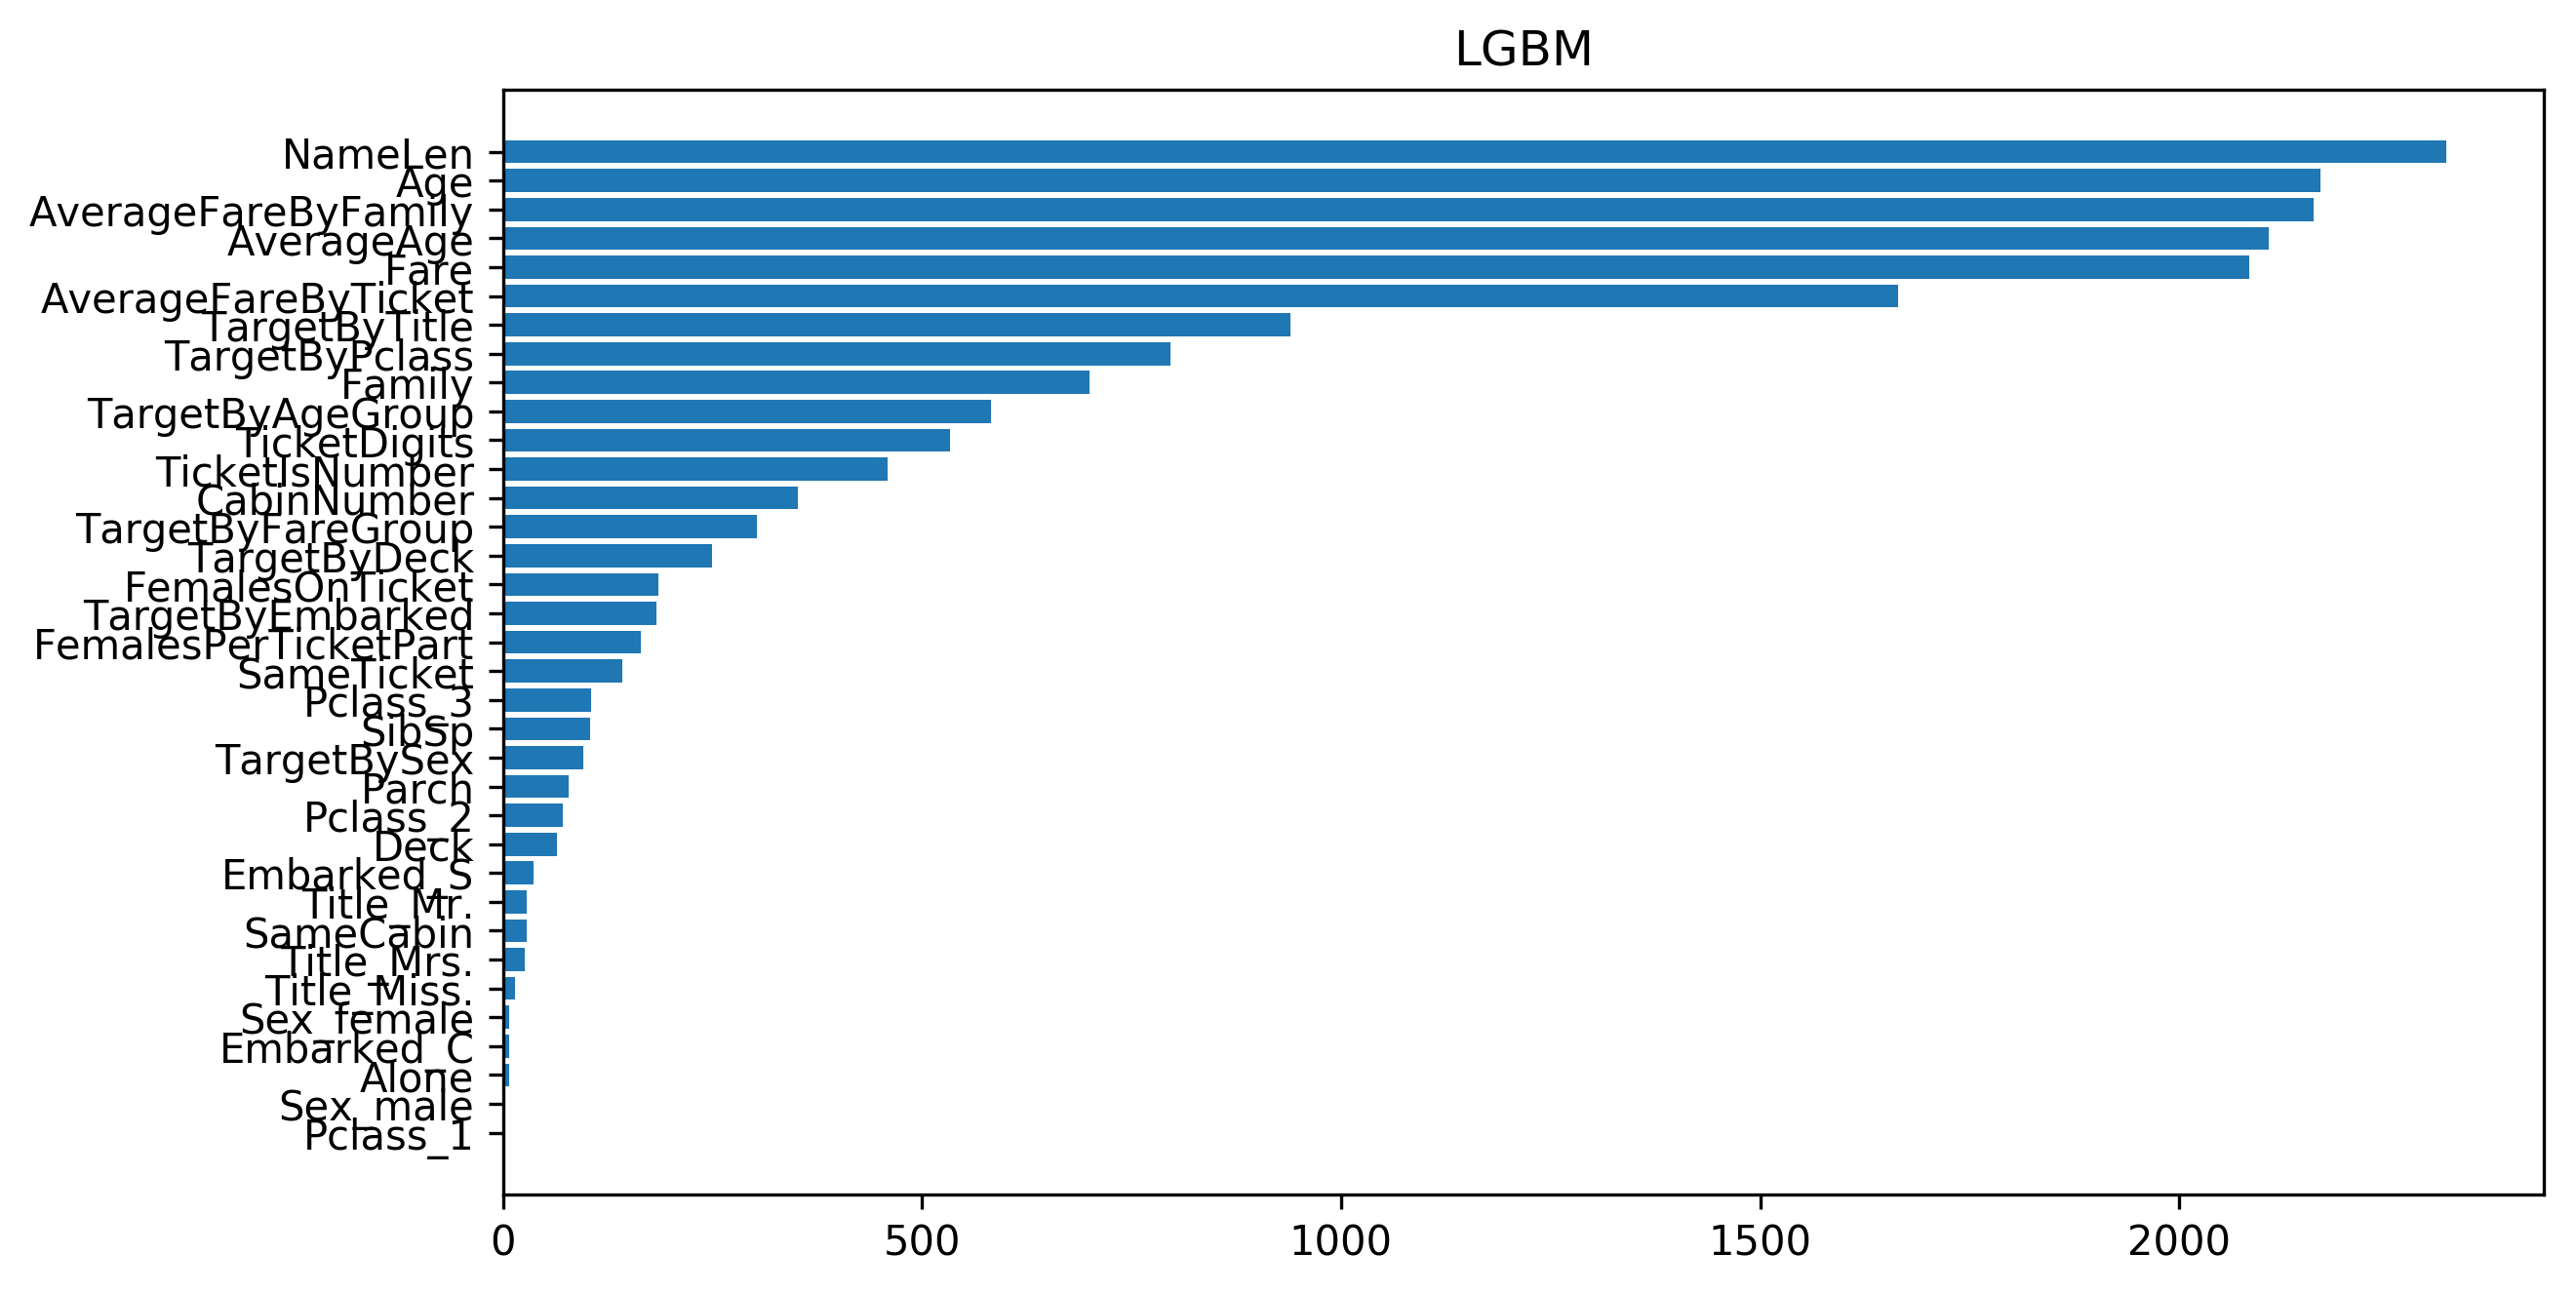

In [18]:
attr2 = {k: v for k, v in zip(indep.columns, gs1.feature_importances_) if v>0}
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = False)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(9, 5), dpi=300, facecolor='w', edgecolor='k')
plt.barh(i1, y1)
plt.title("LGBM")
plt.yticks(i1, x1)
plt.show();